In [ ]:
# Final YOLO-style Object Detection with ResNet18 Backbone on Pascal VOC (Improved)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [ ]:

# --- Step 1: Dataset Setup with Data Augmentation ---
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

def collate_fn(batch):
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    return torch.stack(images), targets

trainset = VOCDetection(root='./', year='2007', image_set='train', download=True, transform=train_transform)
dataloader = DataLoader(trainset, batch_size=8, shuffle=True, collate_fn=collate_fn)

VOC_CLASSES = [
    "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable",
    "dog", "horse", "motorbike", "person", "pottedplant",
    "sheep", "sofa", "train", "tvmonitor"
]


In [ ]:
# --- Step 2: Model ---
class YOLOHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super(YOLOHead, self).__init__()
        self.conv = nn.Conv2d(in_channels, num_anchors * (5 + num_classes), 1)

    def forward(self, x):
        return self.conv(x)

class YOLOModel(nn.Module):
    def __init__(self, num_classes=20, num_anchors=3):
        super(YOLOModel, self).__init__()
        base = torchvision.models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base.children())[:-2])
        self.head = YOLOHead(512, num_anchors, num_classes)

    def forward(self, x):
        x = self.features(x)
        return self.head(x)


Epoch 1 Loss: 3.2252
Epoch 2 Loss: 1.5025
Epoch 3 Loss: 1.2876
Epoch 4 Loss: 1.2193
Epoch 5 Loss: 1.1795
Epoch 6 Loss: 1.1298
Epoch 7 Loss: 1.0813
Epoch 8 Loss: 1.0748
Epoch 9 Loss: 1.0036
Epoch 10 Loss: 0.9742
Epoch 11 Loss: 0.9460
Epoch 12 Loss: 0.9426
Epoch 13 Loss: 0.9319
Epoch 14 Loss: 0.9227
Epoch 15 Loss: 0.8723
Epoch 16 Loss: 0.8310
Epoch 17 Loss: 0.7968
Epoch 18 Loss: 0.7644
Epoch 19 Loss: 0.7584
Epoch 20 Loss: 0.7233


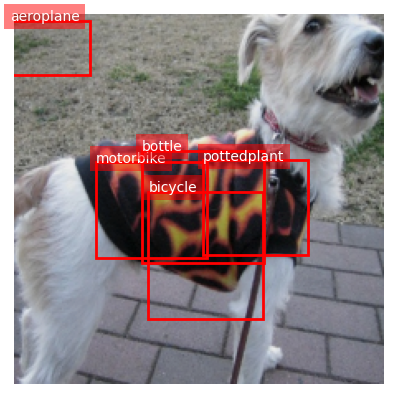

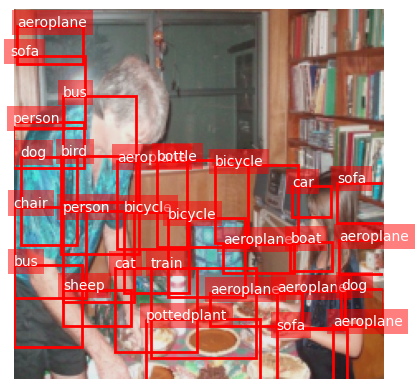

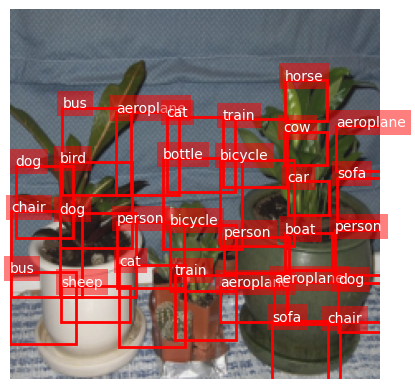

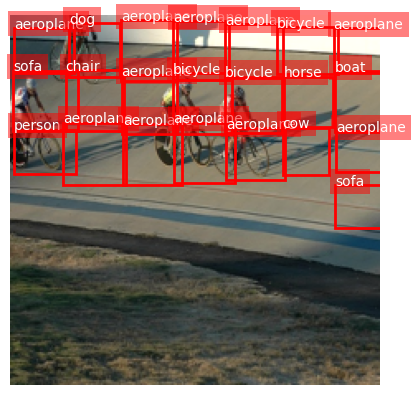

In [4]:




# --- Step 3: YOLO Loss ---
class YOLOSimpleLoss(nn.Module):
    def __init__(self, S=7, B=3, C=20):
        super(YOLOSimpleLoss, self).__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.ce = nn.CrossEntropyLoss()
        self.S = S
        self.B = B
        self.C = C

    def forward(self, pred, target):
        B, _, S, _ = pred.shape
        pred = pred.view(B, self.B, 5 + self.C, S, S).permute(0, 1, 3, 4, 2)
        pred = pred.mean(dim=1).permute(0, 3, 1, 2)

        obj_mask = target[:, 4, :, :] > 0
        noobj_mask = ~obj_mask

        coord_loss = self.mse(pred[:, 0][obj_mask], target[:, 0][obj_mask]) + \
                     self.mse(pred[:, 1][obj_mask], target[:, 1][obj_mask]) + \
                     self.mse(torch.sqrt(torch.abs(pred[:, 2][obj_mask] + 1e-6)),
                              torch.sqrt(torch.abs(target[:, 2][obj_mask] + 1e-6))) + \
                     self.mse(torch.sqrt(torch.abs(pred[:, 3][obj_mask] + 1e-6)),
                              torch.sqrt(torch.abs(target[:, 3][obj_mask] + 1e-6)))

        conf_loss_obj = self.bce(pred[:, 4][obj_mask], target[:, 4][obj_mask])
        conf_loss_noobj = self.bce(pred[:, 4][noobj_mask], target[:, 4][noobj_mask])

        class_loss = self.ce(
            pred[:, 5:].reshape(-1, self.C),
            target[:, 5, :, :].long().reshape(-1)
        )

        total = coord_loss + conf_loss_obj + 0.5 * conf_loss_noobj + class_loss
        return total

# --- Step 4: Target Encoder ---
def target_encoder(targets, S=7, C=20):
    batch_size = len(targets)
    yolo_targets = torch.zeros((batch_size, 5 + C, S, S))

    for b, t in enumerate(targets):
        w = int(t['annotation']['size']['width'])
        h = int(t['annotation']['size']['height'])
        objects = t['annotation']['object']
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            cls_name = obj['name']
            cls_idx = VOC_CLASSES.index(cls_name)
            bbox = obj['bndbox']
            xmin = float(bbox['xmin']) / w
            ymin = float(bbox['ymin']) / h
            xmax = float(bbox['xmax']) / w
            ymax = float(bbox['ymax']) / h
            cx = (xmin + xmax) / 2
            cy = (ymin + ymax) / 2
            bw = xmax - xmin
            bh = ymax - ymin
            i = int(cx * S)
            j = int(cy * S)
            if 0 <= i < S and 0 <= j < S:
                yolo_targets[b, 0, j, i] = cx * S - i
                yolo_targets[b, 1, j, i] = cy * S - j
                yolo_targets[b, 2, j, i] = bw
                yolo_targets[b, 3, j, i] = bh
                yolo_targets[b, 4, j, i] = 1.0
                yolo_targets[b, 5, j, i] = cls_idx
    return yolo_targets

# --- Step 5: Training Loop ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = YOLOModel().to(device)
criterion = YOLOSimpleLoss(S=7, B=3, C=20)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(20):
    model.train()
    running_loss = 0
    for imgs, targets in dataloader:
        imgs = imgs.to(device)
        encoded_targets = target_encoder(targets).to(device)
        preds = model(imgs)
        loss = criterion(preds, encoded_targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(dataloader):.4f}")

# --- Step 6: Post-Training Inference & Visualization ---
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)
    preds = model(imgs).view(imgs.size(0), 3, 25, 7, 7).permute(0, 1, 3, 4, 2)
    preds = preds.mean(dim=1).cpu()  # [B, 7, 7, 25]

    for b in range(min(4, imgs.size(0))):
        img_np = imgs[b].permute(1, 2, 0).cpu().numpy()
        fig, ax = plt.subplots(1)
        ax.imshow(img_np)

        for i in range(7):
            for j in range(7):
                cell = preds[b, i, j]
                conf = torch.sigmoid(cell[4]).item()
                if conf > 0.3:
                    bx = (j + torch.sigmoid(cell[0]).item()) / 7
                    by = (i + torch.sigmoid(cell[1]).item()) / 7
                    bw = cell[2].exp().item() / 7
                    bh = cell[3].exp().item() / 7
                    x1 = (bx - bw / 2) * 224
                    y1 = (by - bh / 2) * 224
                    x2 = (bx + bw / 2) * 224
                    y2 = (by + bh / 2) * 224
                    label = torch.argmax(cell[5:]).item()
                    ax.add_patch(patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                                   linewidth=2, edgecolor='r', facecolor='none'))
                    ax.text(x1, y1, VOC_CLASSES[label], color='white',
                            bbox=dict(facecolor='red', edgecolor='none', alpha=0.5))
        plt.axis('off')
        plt.show()


In [5]:
# Save model weights
torch.save(model.state_dict(), 'yolo_resnet18_weights.pth')
print("✅ Model weights saved.")


✅ Model weights saved.


In [6]:
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    union = (box1[2]-box1[0]) * (box1[3]-box1[1]) + (box2[2]-box2[0]) * (box2[3]-box2[1]) - inter
    return inter / union if union > 0 else 0

def evaluate_image(pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels, iou_thresh=0.5):
    matched = set()
    tp = 0
    for i, pb in enumerate(pred_boxes):
        for j, gb in enumerate(gt_boxes):
            if j in matched or pred_labels[i] != gt_labels[j]:
                continue
            if iou(pb, gb) >= iou_thresh:
                tp += 1
                matched.add(j)
                break
    fp = len(pred_boxes) - tp
    fn = len(gt_boxes) - tp
    return tp, fp, fn


In [7]:
predictions = []
ground_truths = []

for b in range(imgs.size(0)):
    pred_boxes = []
    pred_labels = []
    pred_scores = []

    for i in range(7):
        for j in range(7):
            cell = preds[b, i, j]
            conf = torch.sigmoid(cell[4]).item()
            if conf > 0.3:
                bx = (j + torch.sigmoid(cell[0]).item()) / 7
                by = (i + torch.sigmoid(cell[1]).item()) / 7
                bw = cell[2].exp().item() / 7
                bh = cell[3].exp().item() / 7
                x1 = (bx - bw / 2) * 224
                y1 = (by - bh / 2) * 224
                x2 = (bx + bw / 2) * 224
                y2 = (by + bh / 2) * 224
                pred_boxes.append([x1, y1, x2, y2])
                pred_labels.append(torch.argmax(cell[5:]).item())
                pred_scores.append(conf)

    predictions.append({
        'boxes': pred_boxes,
        'labels': pred_labels,
        'scores': pred_scores
    })

    # Ground truth for current image
    gt_info = trainset[b][1]['annotation']
    w, h = int(gt_info['size']['width']), int(gt_info['size']['height'])
    objects = gt_info['object']
    if not isinstance(objects, list): objects = [objects]
    gt_boxes, gt_labels = [], []
    for obj in objects:
        bbox = obj['bndbox']
        cls = VOC_CLASSES.index(obj['name'])
        x1 = float(bbox['xmin']) / w * 224
        y1 = float(bbox['ymin']) / h * 224
        x2 = float(bbox['xmax']) / w * 224
        y2 = float(bbox['ymax']) / h * 224
        gt_boxes.append([x1, y1, x2, y2])
        gt_labels.append(cls)

    ground_truths.append({'boxes': gt_boxes, 'labels': gt_labels})


In [8]:
def compute_metrics(predictions, ground_truths):
    total_tp, total_fp, total_fn = 0, 0, 0
    for pred, gt in zip(predictions, ground_truths):
        tp, fp, fn = evaluate_image(
            pred['boxes'], pred['labels'], pred['scores'],
            gt['boxes'], gt['labels']
        )
        total_tp += tp
        total_fp += fp
        total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return precision, recall, f1

# Call it at the end of your evaluation block
compute_metrics(predictions, ground_truths)


Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


(0.0, 0.0, 0.0)